In [41]:
# spacy will be used for lemmatization and stop words removal it's better than nltk
!pip install spacy

Defaulting to user installation because normal site-packages is not writeable


In [42]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [1]:
# Data analysis 
import pandas as pd
import numpy as np 

# Data plotting
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size' : 16})

import seaborn as sn
from wordcloud import WordCloud

# Text analysis
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import emoji
import emot
import contractions
import string
import nltk
from nltk.stem import SnowballStemmer 
from nltk.tokenize import word_tokenize

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Save model
import pickle

import time

/home/verpen/anaconda3/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
2022-11-01 13:53:22.355625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 13:53:22.355667: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-01 13:53:37.141649: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-11-01 13:53:37.141743: I tensorflow/stream_executor/cuda/cuda_d

In [2]:
pd.set_option('max_colwidth', 150)


# Loading data

In [3]:
reviews = pd.read_csv('/home/verpen/Downloads/Datasets/Amazon_Reviews_4M/train.csv')

In [4]:
reviews

,Review,Label
0,Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who h...,2
1,The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a ...,2
2,"Amazing!: This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners of Fate"" (which means all the more if yo...",2
3,Excellent Soundtrack: I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and...,2
4,"Remember, Pull Your Jaw Off The Floor After Hearing it: If you've played the game, you know how divine the music is! Every single song tells a sto...",2
...,...,...
3599995,Don't do it!!: The high chair looks great when it first comes out of the box but it is all down hill after that. It is impossible to keep clean. T...,1
3599996,"Looks nice, low functionality: I have used this highchair for 2 kids now and finally decided to sell it because I did not like it. It's a beautifu...",1
3599997,"compact, but hard to clean: We have a small house, and really wanted two of these high chairs for our twins. Space-wize, they are great; they have...",1
3599998,what is it saying?: not sure what this book is supposed to be. It is really just a rehash of very old ideas about Carroll with some pop culture un...,1


# Data analysis


### Analysis of the dataset

In [5]:
# Check if null values exist
reviews.isnull().value_counts()

Review  Label
False   False    3600000
dtype: int64

In [6]:
# Number of positive and negative reviews
reviews['Label'].value_counts()

2    1800000
1    1800000
Name: Label, dtype: int64

In [7]:
# Choose a random subset from the dataset with equal number of 
# positive and negative tweets
subset = 250000
pos_subset = reviews[reviews['Label'] == 2].sample(subset, random_state = 43)
neg_subset = reviews[reviews['Label'] == 1].sample(subset, random_state = 43)

modified_data = pd.concat([pos_subset, neg_subset])
modified_data = modified_data.reset_index(drop=True)

In [9]:
modified_data

,Review,Label
0,"Good novel about gay youth: There are two books in gay romance fiction that I consider to be the Holy Grails of that genre: E.M. Forster's ""Mauric...",2
1,"Tudors Season I: This series is ""Awesome!"" It is addicting. Once you start, there's no way you can stop watching it. I have seen all seasons twice...",2
2,Ah the memories.: What can be said about Rocko's Modern Life? It was a bizarre look at life during the 90's (when cartoons were good) but it's tim...,2
3,Cancer is not a Disese by Andreas Moritz: A very refreshing new look at the subject of cancer. This book provides a very clear understanding on wh...,2
4,better late than never: I more or less stumbled onto this novel after the fact and I really enjoyed the fantastical tale told. I'd like to read so...,2
...,...,...
499995,too expensive: nearly 5 US$ for 2 pieces of hanuta?That is more than 100 % more as u pay in the supermarket!\n,1
499996,Disappointing: Starts out whimsical and ends up self conscious and dull. Found myself skimming at the end to get through it. The subplot about exp...,1
499997,"lots of errors!!!: i never write reviews, but i was so annoyed studying with this book that i just had to. there is very little explanation for wr...",1
499998,"CD not working: I had bought this Cd as a Christmas gift for my son who plays the oboe. By the time Christmas arrived and he opened the Cd, a coup...",1


# Data Preprocessing

In [8]:
abbreviations = {
    "$" : "dollar",
    "€" : "euro",
    "4ao" : "for adults only",
    "1st" : "first", 
    "2nd" : "second", 
    "3rd" : "third",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "canx" : "cancel",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dnt" : "don't",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "emerg" : "emergency",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "haha" : "laugh", 
    "hahaha" : "laugh", 
    "hehe" : "laugh", 
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrs" : "hour",
    "hrh" : "his royal highness",    
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pls" : "please",
    "plz" : "please",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rite" : "right",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sry" : "sorry",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thanks" : "thank",
    "thks" : "thank",
    "tho" : "though",
    "thx" : "thank",
    "tia" : "thanks in advance",
    "til" : "until",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "us" : "united states",
    "usa" : "united states",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "ya" : "you",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

# This abbreviation list is by @nmaguette from Kaggle

In [9]:
def expand_abbreviation(text):
    """ This function takes an abbreviated string
        and returns the expanded version with whitespace 
        replaced by underscore """
    
    expanded_abbr = ''
    expanded_text = ''
    for word in text:
        expanded_abbr = word
        if word in abbreviations: 
            expanded_abbr = abbreviations[word]
            expanded_abbr = expanded_abbr.replace(' ', '_')
        
        expanded_text = expanded_text + expanded_abbr + " "
        expanded_abbr = ''
        
    return expanded_text

In [10]:
emot_obj = emot.core.emot()  

In [11]:
def emoj_emot_to_text(text):
    """ This function converts emojis and emoticons to corresponding text """
    
    # Emoticons  
    emoticons_list = emot_obj.emoticons(text)['mean']
    for emoticon in emoticons_list: 
        emoticon = emoticon.replace(', ', ' ')
        emoticon = emoticon.replace(' ', '_')
        text = text + emoticon + " "       
    
    # Emojis
    text = emoji.demojize(text)
    text = re.sub(':', '', text)
    return text

In [12]:
stop_words = list(STOP_WORDS)

# Exclude from stop words list the following negative words
stop_words.remove('not')
stop_words.remove('never')
stop_words.remove('none')
stop_words.remove('noone')
stop_words.remove('neither')
stop_words.remove('cannot')

In [13]:
def remove_trivial_words(text):  
    """ This function Removes stopwords and words with length of one character or two """
    
    temp = ""
    for word in text.split():
        if  word not in stop_words:
            if len(word) != 1 and len(word) != 2:
                temp += word + " "
    return temp

In [14]:
# Stemming
snowballStemmer = SnowballStemmer(language='english') 

# Measure progress
total = modified_data.shape[0]
progress = 0

def preprocess_texts(text): 
    
    #     Preprocess texts
    text = text.lower() # Convert to lower case
    text = contractions.fix(text) # Remove contractions
    
    #     Remove insignificant characters using regex
    text = re.sub('\S+@\S+.\S+', '', text) # Remove emails
    text = re.sub('@[\S]+', '', text) # Remove mentions starting with @       
    text = re.sub('(http|https):\/\/[\S]*', '', text) # Remove links starting with http or https
    text = re.sub('#+\S*|\.+', '', text) # Remove Hashtags and dots
    text = re.sub(r'(.)\1{2,}', r'\1', text) # Remove characters repetition
    text = re.sub(r'&[\S]+;', '', text) # Remove html tags, such as &amp;  
    text = re.split('(\W+)', text) # Insert a space between characters and punctuations
    
    # Expand abbreviations
    text = expand_abbreviation(text)
    
    # Emojis and Emoticons
    text = emoj_emot_to_text(text)      
    
    text = re.sub('\W', ' ', text)  # Remove remaining punctuations  
    text = re.sub('\d', '', text)  # Remove Numbers    
   
    # Remove trivial words
    text = remove_trivial_words(text)
    
    # Stemming    
    stemmed_token_list = [] 
    for token in text.split(): 
        stemmed_token_list.append(snowballStemmer.stem(token))    
    
    # Progress
    global progress 
    progress += 1
    percent = 100 * (progress / float(total))
    if (percent % 10) == 0:
        print(f'====== {percent} ======')
        
    return stemmed_token_list #Return processed text as a list

In [15]:
# Time processing of texts 
start = time.perf_counter()
modified_data['Tokens'] = modified_data['Review'].apply(preprocess_texts)

end = time.perf_counter()
print(f'Processing time: {end - start}s')

====== 10.0 ======
====== 20.0 ======
====== 30.0 ======
====== 40.0 ======
====== 50.0 ======
====== 60.0 ======
====== 70.0 ======
====== 80.0 ======
====== 90.0 ======
====== 100.0 ======
Processing time: 602.5705028360026s


In [18]:
modified_data

,Review,Label,Tokens
0,"Good novel about gay youth: There are two books in gay romance fiction that I consider to be the Holy Grails of that genre: E.M. Forster's ""Mauric...",2,"[good, novel, gay, youth, book, gay, romanc, fiction, consid, holi, grail, genr, forster, mauric, patricia, nell, warren, runner, gay, romanc, nov..."
1,"Tudors Season I: This series is ""Awesome!"" It is addicting. Once you start, there's no way you can stop watching it. I have seen all seasons twice...",2,"[tudor, season, seri, awesom, addict, start, way, stop, watch, seen, season, twice, start, watch, season, love]"
2,Ah the memories.: What can be said about Rocko's Modern Life? It was a bizarre look at life during the 90's (when cartoons were good) but it's tim...,2,"[memori, said, rocko, modern, life, bizarr, look, life, cartoon, good, timeless, adult, subtl, adult, joke]"
3,Cancer is not a Disese by Andreas Moritz: A very refreshing new look at the subject of cancer. This book provides a very clear understanding on wh...,2,"[cancer, not, dises, andrea, moritz, refresh, new, look, subject, cancer, book, provid, clear, understand, decad, war, cancer, convent, treatment,..."
4,better late than never: I more or less stumbled onto this novel after the fact and I really enjoyed the fantastical tale told. I'd like to read so...,2,"[better, late, never, stumbl, novel, fact, enjoy, fantast, tale, told, like, read, novel, seri]"
...,...,...,...
499995,too expensive: nearly 5 US$ for 2 pieces of hanuta?That is more than 100 % more as u pay in the supermarket!\n,1,"[expens, near, united_st, piec, hanuta, pay, supermarket]"
499996,Disappointing: Starts out whimsical and ends up self conscious and dull. Found myself skimming at the end to get through it. The subplot about exp...,1,"[disappoint, start, whimsic, end, self, conscious, dull, found, skim, end, subplot, expel, jew, place, uncomfort, disappoint, read, star, review]"
499997,"lots of errors!!!: i never write reviews, but i was so annoyed studying with this book that i just had to. there is very little explanation for wr...",1,"[lot, error, never, write, review, annoy, studi, book, littl, explan, wrong, answer, practic, section, practic, problem, subject, review, found, m..."
499998,"CD not working: I had bought this Cd as a Christmas gift for my son who plays the oboe. By the time Christmas arrived and he opened the Cd, a coup...",1,"[not, work, bought, christma, gift, son, play, obo, time, christma, arriv, open, coupl, month, pass, great, disappoint, found, not, work, tri, cle..."


In [16]:
# Convert token lists to string 
def convert_list_str(tokens):
    return ' '.join(tokens)
modified_data['String_tokens'] = modified_data['Tokens'].apply(convert_list_str)
modified_data = modified_data.reset_index(drop=True)
modified_data

,Review,Label,Tokens,String_tokens
0,"Good novel about gay youth: There are two books in gay romance fiction that I consider to be the Holy Grails of that genre: E.M. Forster's ""Mauric...",2,"[good, novel, gay, youth, book, gay, romanc, fiction, consid, holi, grail, genr, forster, mauric, patricia, nell, warren, runner, gay, romanc, nov...",good novel gay youth book gay romanc fiction consid holi grail genr forster mauric patricia nell warren runner gay romanc novel come stori not wei...
1,"Tudors Season I: This series is ""Awesome!"" It is addicting. Once you start, there's no way you can stop watching it. I have seen all seasons twice...",2,"[tudor, season, seri, awesom, addict, start, way, stop, watch, seen, season, twice, start, watch, season, love]",tudor season seri awesom addict start way stop watch seen season twice start watch season love
2,Ah the memories.: What can be said about Rocko's Modern Life? It was a bizarre look at life during the 90's (when cartoons were good) but it's tim...,2,"[memori, said, rocko, modern, life, bizarr, look, life, cartoon, good, timeless, adult, subtl, adult, joke]",memori said rocko modern life bizarr look life cartoon good timeless adult subtl adult joke
3,Cancer is not a Disese by Andreas Moritz: A very refreshing new look at the subject of cancer. This book provides a very clear understanding on wh...,2,"[cancer, not, dises, andrea, moritz, refresh, new, look, subject, cancer, book, provid, clear, understand, decad, war, cancer, convent, treatment,...",cancer not dises andrea moritz refresh new look subject cancer book provid clear understand decad war cancer convent treatment ahead find solution...
4,better late than never: I more or less stumbled onto this novel after the fact and I really enjoyed the fantastical tale told. I'd like to read so...,2,"[better, late, never, stumbl, novel, fact, enjoy, fantast, tale, told, like, read, novel, seri]",better late never stumbl novel fact enjoy fantast tale told like read novel seri
...,...,...,...,...
499995,too expensive: nearly 5 US$ for 2 pieces of hanuta?That is more than 100 % more as u pay in the supermarket!\n,1,"[expens, near, united_st, piec, hanuta, pay, supermarket]",expens near united_st piec hanuta pay supermarket
499996,Disappointing: Starts out whimsical and ends up self conscious and dull. Found myself skimming at the end to get through it. The subplot about exp...,1,"[disappoint, start, whimsic, end, self, conscious, dull, found, skim, end, subplot, expel, jew, place, uncomfort, disappoint, read, star, review]",disappoint start whimsic end self conscious dull found skim end subplot expel jew place uncomfort disappoint read star review
499997,"lots of errors!!!: i never write reviews, but i was so annoyed studying with this book that i just had to. there is very little explanation for wr...",1,"[lot, error, never, write, review, annoy, studi, book, littl, explan, wrong, answer, practic, section, practic, problem, subject, review, found, m...",lot error never write review annoy studi book littl explan wrong answer practic section practic problem subject review found mistak question answe...
499998,"CD not working: I had bought this Cd as a Christmas gift for my son who plays the oboe. By the time Christmas arrived and he opened the Cd, a coup...",1,"[not, work, bought, christma, gift, son, play, obo, time, christma, arriv, open, coupl, month, pass, great, disappoint, found, not, work, tri, cle...",not work bought christma gift son play obo time christma arriv open coupl month pass great disappoint found not work tri clean result unfortun tim...


# Analyze data after processing

In [115]:
# Count the number of tokens in the dataset after processing
num_unique_tokens = 0
num_of_total_tokens = 0
num_pos_tokens = 0
num_neg_tokens = 0
pos_tokens = []
neg_tokens = []
rows = modified_data.shape[0]

for i in range(rows):
    if modified_data['Label'][i] == 1:
        for token in modified_data['Tokens'][i]:
            neg_tokens.append(token)    
    else:
        for token in modified_data['Tokens'][i]:
            pos_tokens.append(token)     

num_pos_tokens = len(pos_tokens)
num_neg_tokens = len(neg_tokens)
num_of_total_tokens = num_pos_tokens + num_neg_tokens
num_unique_tokens = len(set(pos_tokens)) + len(set(neg_tokens))

print(f"""Number of tokens: {num_of_total_tokens}
Number of unique tokens: {num_unique_tokens}
Positive Tokens: {num_pos_tokens}
Negative Tokens: {num_neg_tokens}
Positive Unique Tokens: {len(set(pos_tokens))}
Negative Unique Tokens: {len(set(neg_tokens))}""")

Number of tokens: 17617873
Number of unique tokens: 414645
Positive Tokens: 8539391
Negative Tokens: 9078482
Positive Unique Tokens: 210960
Negative Unique Tokens: 203685


In [116]:
# Calculate words occurrences
def occurrences_of_words(data, reverse=True):
    freq_words_dic = {}
    rows = data.shape[0]
    
    for i in range(rows):
        for word in data['Tokens'][i]:
            if word in freq_words_dic:
                freq = freq_words_dic[word]
                freq_words_dic[word] = freq + 1
            else:
                freq_words_dic[word] = 1
    return sorted(freq_words_dic.items(), key=lambda x: x[1], reverse=reverse)

In [118]:
# Calculate words occurrences in negative reviews
neg_modified_data = modified_data[modified_data['Label'] == 1]
neg_modified_data = neg_modified_data.reset_index(drop=True)

neg_freq_words = occurrences_of_words(neg_modified_data)
neg_freq_words[:20]

[('not', 388905),
 ('book', 149051),
 ('like', 83551),
 ('time', 62328),
 ('work', 60903),
 ('good', 60383),
 ('read', 58241),
 ('movi', 52031),
 ('buy', 49985),
 ('product', 46092),
 ('look', 38912),
 ('money', 37862),
 ('tri', 36584),
 ('disappoint', 35828),
 ('use', 35775),
 ('want', 34517),
 ('great', 33945),
 ('bad', 33928),
 ('better', 32551),
 ('bought', 30575)]

In [119]:
# Calculate words occurances in positive reviews
pos_modified_data = modified_data[modified_data['Label'] == 2]
pos_modified_data = pos_modified_data.reset_index(drop=True)

pos_freq_words = occurrences_of_words(pos_modified_data)
pos_freq_words[:20]

[('not', 183281),
 ('book', 160417),
 ('great', 115630),
 ('good', 82677),
 ('like', 78538),
 ('read', 75310),
 ('love', 73562),
 ('time', 55311),
 ('work', 47085),
 ('movi', 45027),
 ('best', 44371),
 ('album', 36631),
 ('year', 34544),
 ('stori', 34381),
 ('use', 33190),
 ('song', 32085),
 ('look', 31464),
 ('recommend', 30224),
 ('music', 30050),
 ('want', 29199)]

In [23]:
def plot_freq_words(freq_words_list, label, color):
    """ Plot a bar chart with the most frequent words """

    freq_words  = [f_item[0] for f_item in freq_words_list]
    occurrences = [s_item[1] for s_item in freq_words_list]    
    
    # X ticks position
    x_pos = [x*2 for x in range(20)]
    
    plt.figure(figsize=(12, 7))
    plt.bar(x_pos, occurances, align='center', width=1.5, alpha=0.8, color=color, label=label)
    plt.xlabel('Most Frequent Words')
    plt.ylabel('Number of occurances')
    plt.legend()
    plt.xticks(x_pos, freq_words, rotation='vertical')
    plt.show()

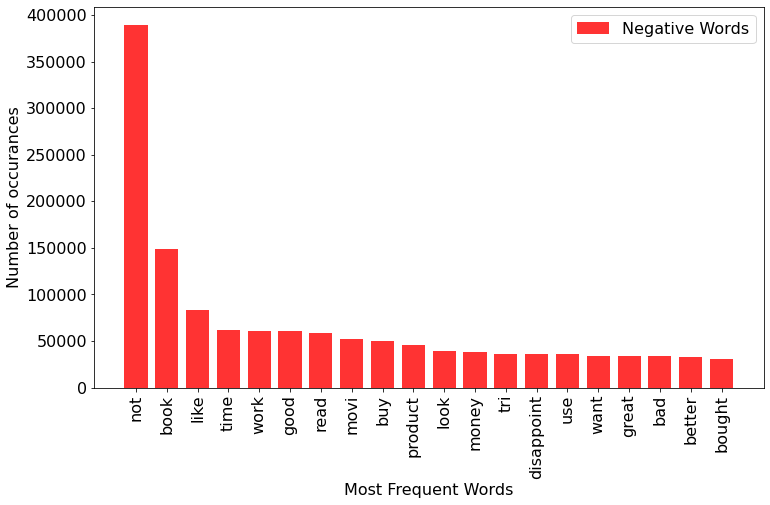

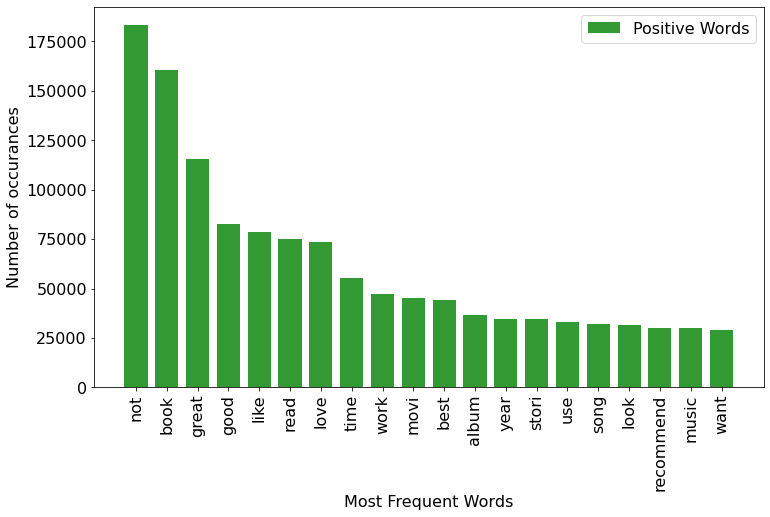

In [24]:
# Plot a bar chart for neg words
plot_freq_words(neg_freq_words[:20], 'Negative Words', 'red')

# Plot a bar chart for pos words
plot_freq_words(pos_freq_words[:20], 'Positive Words', 'green')

In [25]:
# Display a word cloud
def plot_wordcloud(text, words):

    wc = WordCloud(width = 1920, height = 1080, background_color = 'black', max_words = words, colormap='Set2')
    wc.generate(text)    
    
    plt.figure(figsize=(10,10), facecolor="black")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.imshow(wc, interpolation='bilinear')
    plt.show()

In [26]:
# Extract frequent words 
wc_neg_text = [word[0] for word in neg_freq_words]
wc_neg_text = ' '.join(wc_neg_text)

wc_pos_text = [word[0] for word in pos_freq_words]
wc_pos_text = ' '.join(wc_pos_text)

Negative Frequent Words: 


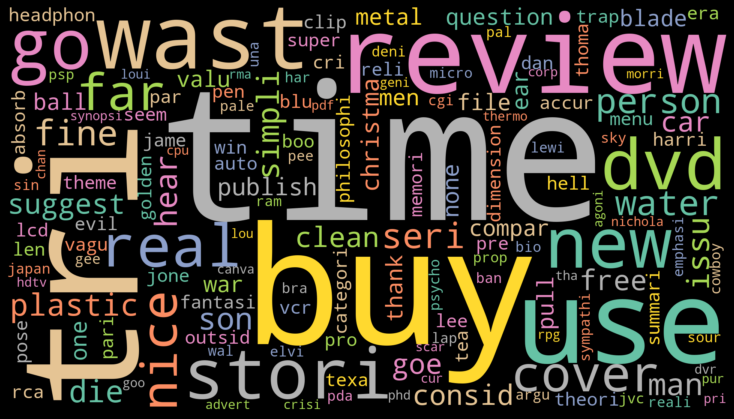


Positive Frequent Words: 


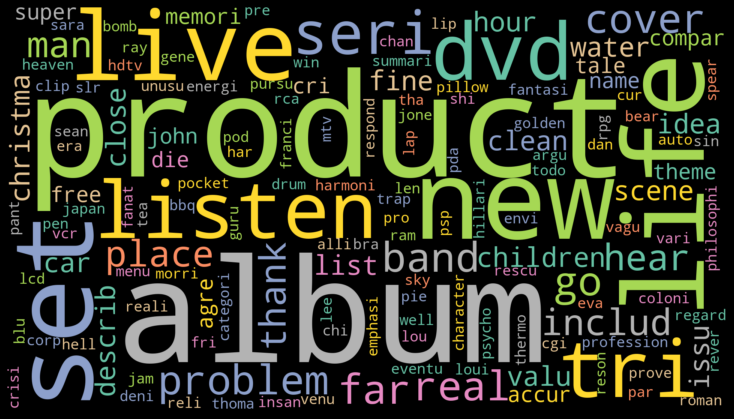

In [27]:
max_words = 150
print('Negative Frequent Words: ')
plot_wordcloud(wc_neg_text, max_words)

print('\nPositive Frequent Words: ')
plot_wordcloud(wc_pos_text, max_words)

# Feature Extraction and Model Training

In [17]:
max_features = 2_000_000
X_train, y_test = train_test_split(modified_data, test_size=0.2, random_state = 0)
print(f'Splitted data: \nTrain Dimensions: {X_train.shape}\nTest Dimensions: {y_test.shape}\n')

tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features = max_features)
tfidf.fit(X_train['String_tokens'])
trained_tfidf = tfidf.transform(X_train['String_tokens'])
test_tfidf = tfidf.transform(y_test['String_tokens'])
print(f'Fitted data: \nTrain Dimensions: {trained_tfidf.shape}\nTest Dimensions: {test_tfidf.shape}')

Splitted data: 
Train Dimensions: (400000, 4)
Test Dimensions: (100000, 4)

Fitted data: 
Train Dimensions: (400000, 2000000)
Test Dimensions: (100000, 2000000)


## Logistic Regression

In [18]:
log_model = LogisticRegression(max_iter=1000, solver = 'saga', multi_class = 'multinomial', C = 3.0)
log_model.fit(trained_tfidf, X_train['Label'])
log_model.score(test_tfidf, y_test['Label'])

0.91266

## Linear SVM

In [19]:
svm_model_linear = LinearSVC()
svm_model_linear.fit(trained_tfidf, X_train['Label'])
svm_model_linear.score(test_tfidf, y_test['Label'])

0.91321

## Decision Tree

In [31]:
dtree_model = DecisionTreeClassifier()
dtree_model.fit(trained_tfidf, X_train['Label'])
dtree_model.score(test_tfidf, y_test['Label'])

0.78855

## Random Forest

In [32]:
rforest_model = RandomForestClassifier()
rforest_model.fit(trained_tfidf, X_train['Label'])
rforest_model.score(test_tfidf, y_test['Label'])

0.88078

## Naive Bayes - MultinomialNB

In [33]:
nb_multinomial_model = naive_bayes.MultinomialNB()
nb_multinomial_model.fit(trained_tfidf, X_train['Label'])
nb_multinomial_model.score(test_tfidf, y_test['Label'])

0.87929

## Naive Bayes - BernoulliNB

In [34]:
nb_bernoulli_model = naive_bayes.BernoulliNB()
nb_bernoulli_model.fit(trained_tfidf, X_train['Label'])
nb_bernoulli_model.score(test_tfidf, y_test['Label'])

0.87515

# Saving the best model

In [128]:
# pickle.dump(svm_model_linear, open('/home/verpen/Downloads/Datasets/Models/SA_Amazon_Reviews_SVM_913.pkl', 'wb'))

              precision    recall  f1-score   support

           1       0.92      0.91      0.91     50108
           2       0.91      0.92      0.91     49892

    accuracy                           0.91    100000
   macro avg       0.91      0.91      0.91    100000
weighted avg       0.91      0.91      0.91    100000

[[45399  4709]
 [ 4178 45714]]


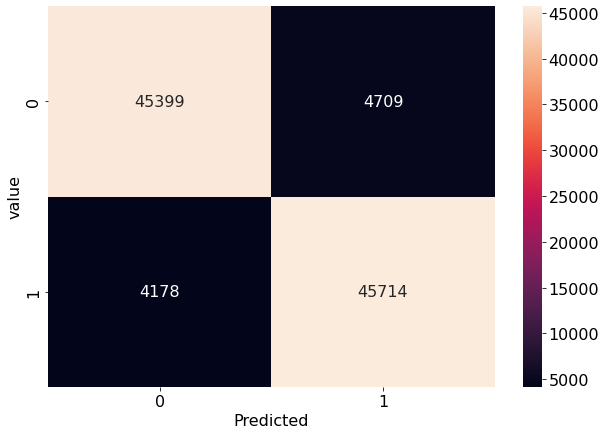

In [30]:
# Print an analysis for SVM
predictions = svm_model_linear.predict(test_tfidf)

# Print a Classification report
print(classification_report(y_test['Label'], predictions))
cm = confusion_matrix(y_test['Label'], predictions, labels=[1, 2])
print(cm)
    
# Plot a heatmap
plt.figure(figsize= (10, 7))
sn.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('value')
plt.show()

              precision    recall  f1-score   support

           1       0.92      0.91      0.91     50108
           2       0.91      0.92      0.91     49892

    accuracy                           0.91    100000
   macro avg       0.91      0.91      0.91    100000
weighted avg       0.91      0.91      0.91    100000

[[45416  4692]
 [ 4083 45809]]


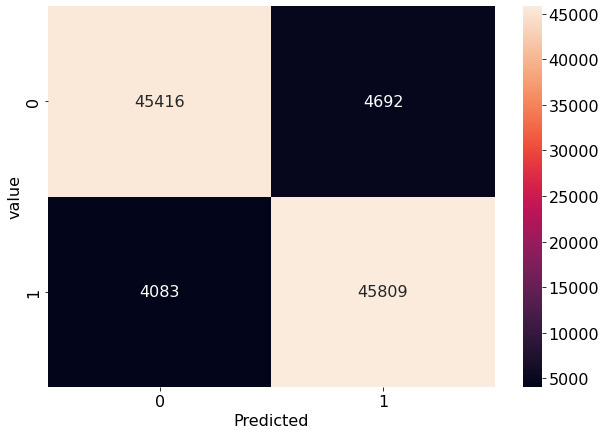

In [31]:
# Print an analysis for LR
predictions = log_model.predict(test_tfidf)

# Print a Classification report
print(classification_report(y_test['Label'], predictions))
cm = confusion_matrix(y_test['Label'], predictions, labels=[1, 2])
print(cm)
    
# Plot a heatmap
plt.figure(figsize= (10, 7))
sn.heatmap(cm, annot=True, fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('value')
plt.show()

# Testing the model 

In [20]:
def pipeline(model, test_data):
    
    # Preprocessing
    print("Processing texts....")
    start = time.perf_counter()
    test_data['processed_texts'] = test_data['Review'].apply(preprocess_texts)
    test_data['string_texts'] = test_data['processed_texts'].apply(convert_list_str)
    end = time.perf_counter()    
    print(f'Processing time: {end - start}')
    
    # Transforming processed text using tfidf vectorizer initiated and fitted above
    print("Transforming texts to features....")
    test_tfidf = tfidf.transform(test_data['string_texts'])
    
    # Predict
    print("Predicting....")
    predictions = model.predict(test_tfidf)
    
    # Print a Classification report
    print(classification_report(test_data['Label'], predictions))
    cm = confusion_matrix(test_data['Label'], predictions, labels=[1, 2])
    print(cm)
    
    # Plot a heatmap
    plt.figure(figsize= (10, 7))
    sn.heatmap(cm, annot=True, fmt='.0f')
    plt.xlabel('Predicted')
    plt.ylabel('value')
    plt.show()
    
    # Plot a pie 
    (unique, counts) = np.unique(predictions, return_counts=True)
    print(f'Unique: {unique}\t\tCounts: {counts}')
    
    neg_texts_counts = counts[0]
    pos_texts_counts = counts[1]
    labels = ["Negative", "Positive"]
    plt.pie(counts, labels=labels, shadow=True, autopct="%1.2f%%")

# Model testing with Amazon Reviews dataset

In [21]:
# Another test
amazon_reviews = pd.read_csv('/home/verpen/Downloads/Datasets/Amazon_Reviews_4M/test.csv') # 400k reviews
amazon_reviews = amazon_reviews.sample(100000)
amazon_reviews = amazon_reviews.reset_index(drop=True)
amazon_reviews

,Review,Label
0,harry potter chamber of secrets: Rented video from amazon.com because my girlfriend had never seen it. She was actually showing interest in the st...,1
1,"Title....Absolutely love it!: I absolutely love it!...It is full of cool, colorful fashion illustrations. It makes drawing the fashion figure so s...",2
2,"It does what I wanted: I was looking for a clock radio with buttons to set radio stations, making it easier to change stations. I was also having ...",2
3,"loud hum all the time: This product has some perks, It's nice looking, the headphones fit nicely, the charging station is neat. However the draw b...",1
4,"More about aesthetics than function: This is a very good-looking filter. We used to live in Orlando where the water tastes like sewage, so a good ...",1
...,...,...
99995,"GREAT HORROR/COMEDY!!! WAXWORK RULES!!!!!!: This movie is great!!! My favorite part is the werewolf segment. I liked the ""It's my party"" song at t...",2
99996,"Battery Latch Broken - HP Lost Computer - Claims No Responsibility: Amazon is a great company and have many great buys on line here, however HP Bu...",1
99997,"Nothing new here folks...: It's more the type of album I listen to once, take out of player, throw in back seat of my car, and it disappears from ...",1
99998,"One time use...: I purchased this set for the larger sizes mainly, so that I could remove some foot pegs on a dirt bike. I was able to remove & re...",1


Processing texts....
====== 120.0 ======
Processing time: 90.49165729300148
Transforming texts to features....
Predicting....
              precision    recall  f1-score   support

           1       0.92      0.91      0.91     49978
           2       0.91      0.92      0.91     50022

    accuracy                           0.91    100000
   macro avg       0.91      0.91      0.91    100000
weighted avg       0.91      0.91      0.91    100000

[[45392  4586]
 [ 4193 45829]]


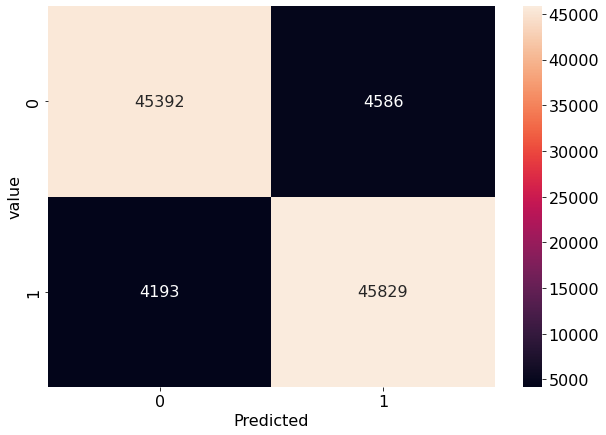

Unique: [1 2]		Counts: [49585 50415]


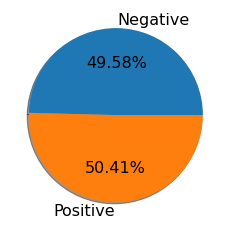

In [22]:
pipeline(svm_model_linear, amazon_reviews)

# Model testing with IMDb Movie Reviews dataset

In [24]:
movie_reviews = pd.read_csv('/home/verpen/Downloads/Datasets/imdb/IMDb_Moview_Reviews.zip')
movie_reviews = movie_reviews.rename(columns={'review':'Review', 'sentiment': 'Label'})
movie_reviews

,Review,Label
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened ...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometim...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted ...",positive
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />Thi...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. Thi...",positive
...,...,...
49995,"I thought this movie did a down right good job. It wasn't as creative or original as the first, but who was expecting it to be. It was a whole lot...",positive
49996,"Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ran continually over the overacted script, and a c...",negative
49997,"I am a Catholic taught in parochial elementary schools by nuns, taught by Jesuit priests in high school & college. I am still a practicing Catholi...",negative
49998,"I'm going to have to disagree with the previous comment and side with Maltin on this one. This is a second rate, excessively vicious Western that ...",negative


In [25]:
movie_reviews['Label'] = movie_reviews['Label'].apply(lambda x: 2 if x == 'positive' else 1)
movie_reviews

,Review,Label
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened ...",2
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometim...",2
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted ...",2
3,Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />Thi...,1
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. Thi...",2
...,...,...
49995,"I thought this movie did a down right good job. It wasn't as creative or original as the first, but who was expecting it to be. It was a whole lot...",2
49996,"Bad plot, bad dialogue, bad acting, idiotic directing, the annoying porn groove soundtrack that ran continually over the overacted script, and a c...",1
49997,"I am a Catholic taught in parochial elementary schools by nuns, taught by Jesuit priests in high school & college. I am still a practicing Catholi...",1
49998,"I'm going to have to disagree with the previous comment and side with Maltin on this one. This is a second rate, excessively vicious Western that ...",1


Processing texts....
====== 130.0 ======
Processing time: 151.47298931499972
Transforming texts to features....
Predicting....
              precision    recall  f1-score   support

           1       0.86      0.90      0.88     25000
           2       0.90      0.85      0.88     25000

    accuracy                           0.88     50000
   macro avg       0.88      0.88      0.88     50000
weighted avg       0.88      0.88      0.88     50000

[[22564  2436]
 [ 3657 21343]]


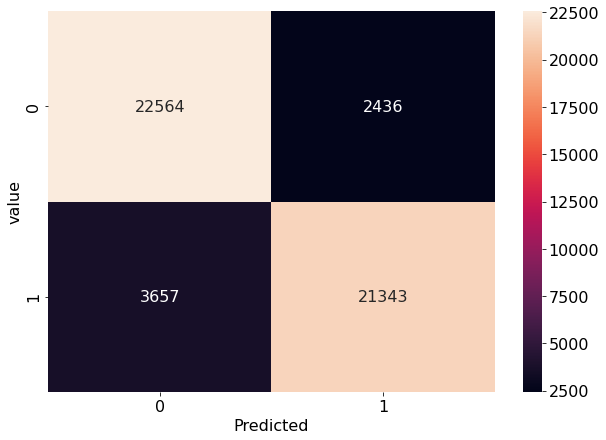

Unique: [1 2]		Counts: [26221 23779]


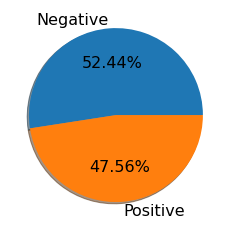

In [26]:
pipeline(svm_model_linear, movie_reviews)

## Model testing with Pang's Movie Reviews dataset

In [123]:
# https://github.com/anurag3290/IMDB-Sentiment-Analysis
pang_movies = pd.read_csv('/home/verpen/Downloads/Datasets/Pang/Movie_Reviews_2002/Movie_Reviews.csv')
pang_movies

,Unnamed: 0,Review,Label
0,0,['the brady bunch movie is less a motion picture than a minor pop event . forget your reruns and forget your nick at nite ; this dead-on recreatio...,1
1,1,"['this movie tries to present itself as the sequel to jan de bont\'s debut as a director , 1994 surprise hit speed . but the only thing the two mo...",1
2,2,"['directed by brian helgeland . cast : mel gibson , gregg henry , maria bello , david paymer , william devane , lucy alexis liu , bill duke , debo...",1
3,3,"['director : brian depalma writer : david koepp ( story by brian depalma and david koepp ) starring : nicolas cage , gary sinise , carla gugino , ...",1
4,4,"['living out loud written and directed by richard lagravenese . photography , john bailey . editing , gregory & lynzee klingman . production desig...",1
...,...,...,...
1395,1395,"[""the sixth sense -a review by bill chambers ( 6sense@filmfreakcentral . net ) starring bruce willis , haley joel osment , toni collette , olivia...",2
1396,1396,"['i love japanese anime on the big screen . the gorgeous colors , the daunting cel animation detailing the smallest blades of grass , the complex ...",2
1397,1397,"['for just a couple of years now , a certain film director has been doing for action films what marisa tomei did earlier this year for the "" love ...",2
1398,1398,"['rushmore ( m ) . ( touchstone/beuna vista international ) director : wes anderson stars : jason schwartzman , olivia williams , bill murray , br...",2


Processing texts....
Processing time: 12.880958153000392
Transforming texts to features....
Predicting....
              precision    recall  f1-score   support

           1       0.81      0.88      0.85       700
           2       0.87      0.80      0.83       700

    accuracy                           0.84      1400
   macro avg       0.84      0.84      0.84      1400
weighted avg       0.84      0.84      0.84      1400

[[617  83]
 [143 557]]


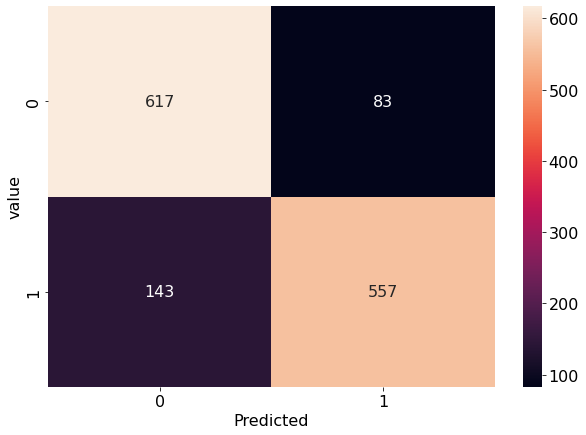

Unique: [1 2]		Counts: [760 640]


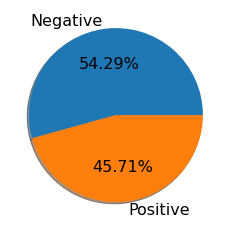

In [125]:
pipeline(svm_model_linear, pang_movies)